<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/main/benchmark_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install nussl, voicesep et import systématiques

## Install de nussl

In [ ]:
!pip install nussl

     |████████████████████████████████| 239 kB 16.1 MB/s 
     |████████████████████████████████| 153 kB 68.0 MB/s 
     |████████████████████████████████| 3.3 MB 63.3 MB/s 
     |████████████████████████████████| 251 kB 73.7 MB/s 
     |████████████████████████████████| 51 kB 66 kB/s 
     |████████████████████████████████| 310 kB 61.0 MB/s 
     |████████████████████████████████| 90 kB 7.9 MB/s 
     |████████████████████████████████| 963 kB 53.8 MB/s 
     |████████████████████████████████| 130 kB 66.1 MB/s 
     |████████████████████████████████| 6.2 MB 48.6 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=495bbb03db08487deaed66913e8a6338c20048456936d7f04064ab2806c73fb2
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=5530aad0367554a9ee23883929787de29c7c51407667a7722626d9302592938f
  Stored in 

## Installation de voicesep

In [ ]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-rtbu3haz
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-rtbu3haz
  Created wheel for voice-separator: filename=voice_separator-0.0.1-py3-none-any.whl size=7671 sha256=a2707e30f9502a5452d385413b8cfe87e99006f81fc8f1f51f98c994ad48b5cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-5vhh6r2a/wheels/89/ad/91/9cded351057b1a842fbbfa97f091da426d85036b0efd2e0273
Successfully built voice-separator


## Imports

In [ ]:
# Chargement des paquets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import librosa
import nussl
import numpy as np
import os,sys
import glob
from sklearn.preprocessing import MinMaxScaler
#import importlib # pour mise à jour des lib en développement


SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Préparation de l'environnement de travail

**Cette étape est cruciale pour le bon fonctionnement du notebook.**

## Montage du drive

Dans ce notebook, le montage du drive sert principalement à récupérer les modèle UNet existants et à sauvegarder les métriques calculées, mais aussi potentiellement à positionner le dossier temporaire des prédictions Demucs et Spleeter.

In [ ]:
from google.colab import drive # import drive from google colab
drive.mount("/content/drive")  # we mount the google drive at /content/drive

Mounted at /content/drive


## Définition des emplacements des dossiers

Choix d'un nouveau dossier de sauvegarde pour les métriques.

In [ ]:
metrics_path = os.path.join("/content", "drive", "MyDrive", "Projet Datascientest", "metrics")

# Création automatique du dossier de métriques si nécessaire
if not os.path.exists(metrics_path):
  os.mkdir(metrics_path)

Sélection du dossier existant de stockage des modèles UNet.

In [ ]:
unets_path = os.path.join("/content", "drive", "MyDrive", "Projet Datascientest", "UNet")

Sélection du dossier musdb18 contenant les musiques.

In [ ]:
musdb_path = os.path.join("/content", "drive", "MyDrive", "Projet Datascientest", "musdb18")

## Choix du dossier temporaire pour les prédictions

Ce dossier peut être positionné, au choix :
- sur le drive qui a été connecté
- en local dans colab

In [ ]:
# Pour un dossier sur drive
tmp_path = os.path.join("/content", "drive", "MyDrive","Projet Datascientest", "tmp")
# Pour un dossier en local
#tmp_path = "tmp"

# Création automatique des chemins si nécessaire
if not os.path.exists(tmp_path):
  os.mkdir(tmp_path)
in_path = os.path.join(tmp_path,"input")
if not os.path.exists(in_path):
  os.mkdir(in_path)
out_path = os.path.join(tmp_path,"output")
if not os.path.exists(out_path):
  os.mkdir(out_path)

# Comparaison sur toutes les musiques


## Téléchargement des données

In [ ]:
# Récupération de la base de données musdb18 depuis google drive
from voicesep.core import get_musdb_data

musdb_test = get_musdb_data(gather_accompaniment=True,folder=musdb_path,subfolder="test")

## Méthodes existantes

In [ ]:
from voicesep.models import evaluate_dict_models

### Méthodes primitives

La méthode Timbre clustering est très gourmande en RAM, et requiert un important sous-échantillonnage. Elle est donc traitée séparément des autres méthodes primitives.

On peut remarquer que, grâce à une défintion par lambda fonctions, les objets des méthodes ne sont pas construits simultanément afin de ne pas surcharger la RAM. 

In [ ]:
methods = {
           #"TimbreClustering": lambda mix,truth: nussl.separation.primitive.TimbreClustering(mix,2,50),
           "Repet": lambda mix,truth: nussl.separation.primitive.Repet(mix),
           "RepetSim": lambda mix,truth: nussl.separation.primitive.RepetSim(mix),
           "FT2D": lambda mix,truth: nussl.separation.primitive.FT2D(mix),
           "HPSS": lambda mix,truth: nussl.separation.primitive.HPSS(mix),
           "High-Low Pass": lambda mix,truth: nussl.separation.benchmark.HighLowPassFilter(mix, 1000),
           "Ideal Binary Mask": lambda mix,truth: nussl.separation.benchmark.IdealBinaryMask(mix,truth),
           "Ideal Ratio Mask": lambda mix,truth: nussl.separation.benchmark.IdealRatioMask(mix,truth),
          }

freq = 16384
for i in range(len(musdb_test)):
  item = musdb_test[i]
  mix = item["mix"]
  sources = item['sources']
  truth = [sources['drums+bass+other'], sources['vocals']]
  mix.resample(freq,res_type='kaiser_fast')
  truth[0].resample(freq,res_type='kaiser_fast')
  truth[1].resample(freq,res_type='kaiser_fast')

  scores_list = []
  for name,method in methods.items():
    print(i,name)
    scores_list.append(evaluate_dict_models({name:method(mix,truth)}, truth, visualize=False, report=False))
  scores = pd.concat(scores_list)
  save_path = os.path.join(metrics_path, f"{i}_primitive.csv")
  scores.to_csv(save_path)

La méthode Timbre clustering est donc utilisée ici, avec un sous-échantillonnage 4 fois plus léger.

In [ ]:
methods = {
           "TimbreClustering": lambda mix,truth: nussl.separation.primitive.TimbreClustering(mix,2,50),
           #"Repet": lambda mix,truth: nussl.separation.primitive.Repet(mix),
           #"RepetSim": lambda mix,truth: nussl.separation.primitive.RepetSim(mix),
           #"FT2D": lambda mix,truth: nussl.separation.primitive.FT2D(mix),
           #"HPSS": lambda mix,truth: nussl.separation.primitive.HPSS(mix),
           #"High-Low Pass": lambda mix,truth: nussl.separation.benchmark.HighLowPassFilter(mix, 1000),
           #"Ideal Binary Mask": lambda mix,truth: nussl.separation.benchmark.IdealBinaryMask(mix,truth),
           #"Ideal Ratio Mask": lambda mix,truth: nussl.separation.benchmark.IdealRatioMask(mix,truth),
          }

freq = 4096
for i in range(len(musdb_test)):
  item = musdb_test[i]
  mix = item["mix"]
  sources = item['sources']
  truth = [sources['drums+bass+other'], sources['vocals']]
  mix.resample(freq,res_type='kaiser_fast')
  truth[0].resample(freq,res_type='kaiser_fast')
  truth[1].resample(freq,res_type='kaiser_fast')

  scores_list = []
  for name,method in methods.items():
    print(i,name)
    scores_list.append(evaluate_dict_models({name:method(mix,truth)}, truth, visualize=False, report=False))
  scores = pd.concat(scores_list)
  save_path = os.path.join(metrics_path, f"{i}_primitive_TC.csv")
  scores.to_csv(save_path)

### Méthodes Demucs deep

#### Installation de Demucs

In [ ]:
!pip install demucs

#### Calcul des scores

In [ ]:
from voicesep.demucs import DemucsModel

for i in range(len(musdb_test)):
  item = musdb_test[i]
  mix = item["mix"]
  sources = item['sources']
  truth = [sources['drums+bass+other'], sources['vocals']]

  sep_class_dict = {
                    "Demucs MDX": DemucsModel(mix,"mdx",in_path,out_path),
                    "Demucs MDX EXTRA": DemucsModel(mix,"mdx_extra",in_path,out_path),
                    "Demucs MDX Q": DemucsModel(mix,"mdx_q",in_path,out_path),
                    "Demucs MDX EXTRA Q": DemucsModel(mix,"mdx_extra_q",in_path,out_path),
                   }
  print(i)
  scores = evaluate_dict_models(sep_class_dict, truth, visualize=False, report=False)
  save_path = os.path.join(metrics_path, f"{i}_demucs.csv")
  scores.to_csv(save_path)

### Méthodes Open-Unmix deep

#### Installation d'Open-Unmix

In [ ]:
!pip install openunmix

#### Calcul des scores

**ATTENTION : Il arrive que les modèles Open-Unmix saturent la RAM, notamment sur les musiques longues.**

In [ ]:
from voicesep.openunmix import OpenUnmixModel

for i in range(len(musdb_test)):
  item = musdb_test[i]
  mix = item["mix"]
  sources = item['sources']
  truth = [sources['drums+bass+other'], sources['vocals']]

  sep_class_dict = {
                    #"OpenUnmix UMXL": OpenUnmixModel(mix,"umxl"),
                    #"OpenUnmix UMXHQ": OpenUnmixModel(mix,"umxhq"),
                    "OpenUnmix UMX": OpenUnmixModel(mix,"umx"),
                   }
  print(i)
  scores = evaluate_dict_models(sep_class_dict, truth, visualize=False, report=False)
  save_path = os.path.join(metrics_path, f"{i}_openunmix.csv")
  scores.to_csv(save_path)

### Méthodes Spleeter deep

#### Installation de Spleeter

In [ ]:
!pip install spleeter

#### Calcul des scores

In [ ]:
from voicesep.spleeter import SpleeterModel

for i in range(len(musdb_test)):
  item = musdb_test[i]
  mix = item["mix"]
  sources = item['sources']
  truth = [sources['drums+bass+other'], sources['vocals']]

  sep_class_dict = {
                    "Spleeter": SpleeterModel(mix,in_path,out_path),
                   }
  print(i)
  scores = evaluate_dict_models(sep_class_dict, truth, visualize=False, report=False)
  save_path = os.path.join(metrics_path, f"{i}_spleeter.csv")
  scores.to_csv(save_path)

## UNets construits

Définition de la loss personnalisée, qui sera appelée si besoin plus bas.

In [ ]:
import tensorflow as tf

def myloss(y_true, y_pred):
  return tf.math.reduce_sum(abs(y_true - y_pred)) + abs(tf.math.reduce_sum(y_true) - tf.math.reduce_sum(y_pred))

Des modèle UNet avec différents jeux de paramètres ont été construits. Les scores sont calculés pour chaque jeu de paramètres séparément.

Tout d'abord, les modèles avec échantillonnage à 8kHz.

In [ ]:
from tensorflow.keras.models import load_model
from voicesep.unet import UNetModel

freq = 8192
window_length = 1023
hop_length = 768
patch_size = 128
nfreq = 512

models = {
          "model_20220202_quick":{"myloss":myloss},
          "model_20220127_long_train_sd+ds":{"myloss":myloss},
          "model_20220101_init":{},
         }

unets = {model:load_model(os.path.join(unets_path,model),custom_objects=data)
         for model,data in models.items()}

for i in range(len(musdb_test)):
  data = musdb_test[i]
  truth = [data["sources"]['drums+bass+other'], data["sources"]['vocals']]
  truth[0].resample(freq,res_type='kaiser_fast')
  truth[1].resample(freq,res_type='kaiser_fast')
  truth[0].to_mono()
  truth[1].to_mono()

  sep_class_dict = {
                    name: UNetModel(data["mix"],
                                    unet,
                                    freq=freq,
                                    window_length=window_length,
                                    hop_length=hop_length,
                                    patch_size=patch_size,
                                    nfreq=nfreq)
                    for name,unet in unets.items()
                   }
  print(i)  
  scores = evaluate_dict_models(sep_class_dict, truth, visualize=False, report=False)
  save_path = os.path.join(metrics_path, f"{i}_unet_8k.csv")
  scores.to_csv(save_path)

Puis les modèles échantillonés à 4kHz.

In [ ]:
from tensorflow.keras.models import load_model
from voicesep.unet import UNetModel

freq = 4096
window_length = 511
hop_length = 384
patch_size = 64
nfreq = 256

models = {
          "model_20220207_aug=8_4k":{},
          "model_20220206_90x2_2.3M_4k_L2":{},
          "model_20220206_90x2_2.3M_4k_L2_long":{},
          "model_20220202_100x2_2.3M_maxepoch":{},
         }

unets = {model:load_model(os.path.join(unets_path,model),custom_objects=data)
         for model,data in models.items()}

for i in range(len(musdb_test)):
  data = musdb_test[i]
  truth = [data["sources"]['drums+bass+other'], data["sources"]['vocals']]
  truth[0].resample(freq,res_type='kaiser_fast')
  truth[1].resample(freq,res_type='kaiser_fast')
  truth[0].to_mono()
  truth[1].to_mono()

  sep_class_dict = {
                    name: UNetModel(data["mix"],
                                    unet,
                                    freq=freq,
                                    window_length=window_length,
                                    hop_length=hop_length,
                                    patch_size=patch_size,
                                    nfreq=nfreq)
                    for name,unet in unets.items()
                   }
  print(i)  
  scores = evaluate_dict_models(sep_class_dict, truth, visualize=False, report=False)
  save_path = os.path.join(metrics_path, f"{i}_unet_4k.csv")
  scores.to_csv(save_path)

## Concaténation de tous les scores

Il est à noter que nous nous intéressons ici uniquement aux scores concernant la prédiction de la voix.

Les méthodes sont ordonnées par score moyen croissant.

*Note : si vous souhaitez seulement charger le dataframe de scores de référence, vous pouvez passer directement à son chargement, quelques cellules plus bas.*

In [ ]:
metric_files = glob.glob(os.path.join(metrics_path,"*.csv"))
df = pd.concat([pd.read_csv(file,header=1,index_col=0).dropna()[["SI-SDR.1"]].rename(columns={("SI-SDR.1"):file.split(os.sep)[-1].split("_")[0]})
                for file in metric_files if "all_scores" not in file],axis=1)
def join(x):
  return x[x.notnull()]
df = df.groupby(level=0,axis=1).apply(lambda x: x.apply(join, axis=1))
df.columns = [int(col[0]) for col in df.columns]
df = df.transpose()
df = df.reindex(df.mean().sort_values().index, axis=1)

### Sauvegarde du dataframe construit

In [ ]:
df.to_csv(os.path.join(metrics_path,"all_scores.csv"))

### Chargement du dataframe de référence sur GitHub

In [ ]:
url_liste_musdb18 = "https://raw.githubusercontent.com/MickaRiv/ProjetDatascientest-VoiceSeparator/main/data/all_scores.csv"
df=pd.read_csv(url_liste_musdb18,index_col=0)

## Affichage des scores

### SI-SDR

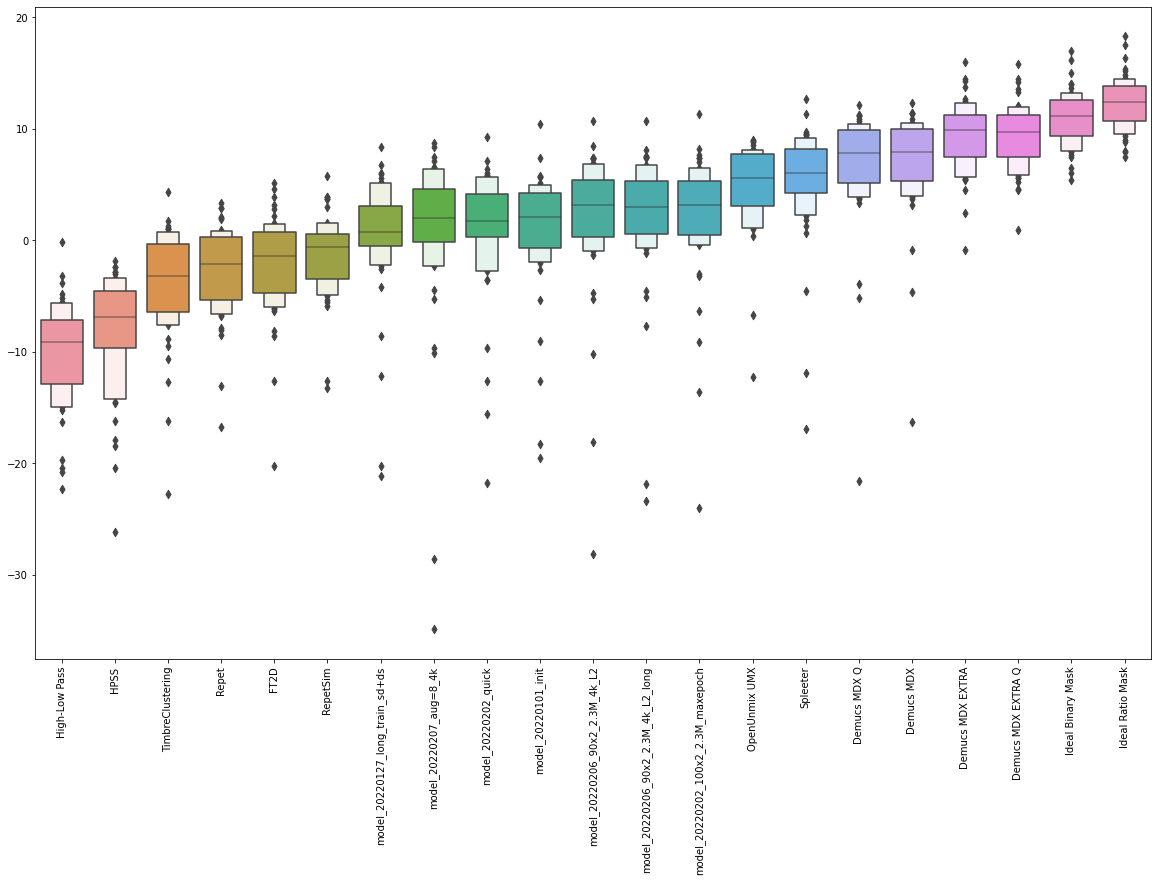

In [ ]:
plt.figure(figsize=(20,12))
sns.boxenplot(data=df)
plt.xticks(rotation=90)
plt.show()

### SI-SDR normalisés

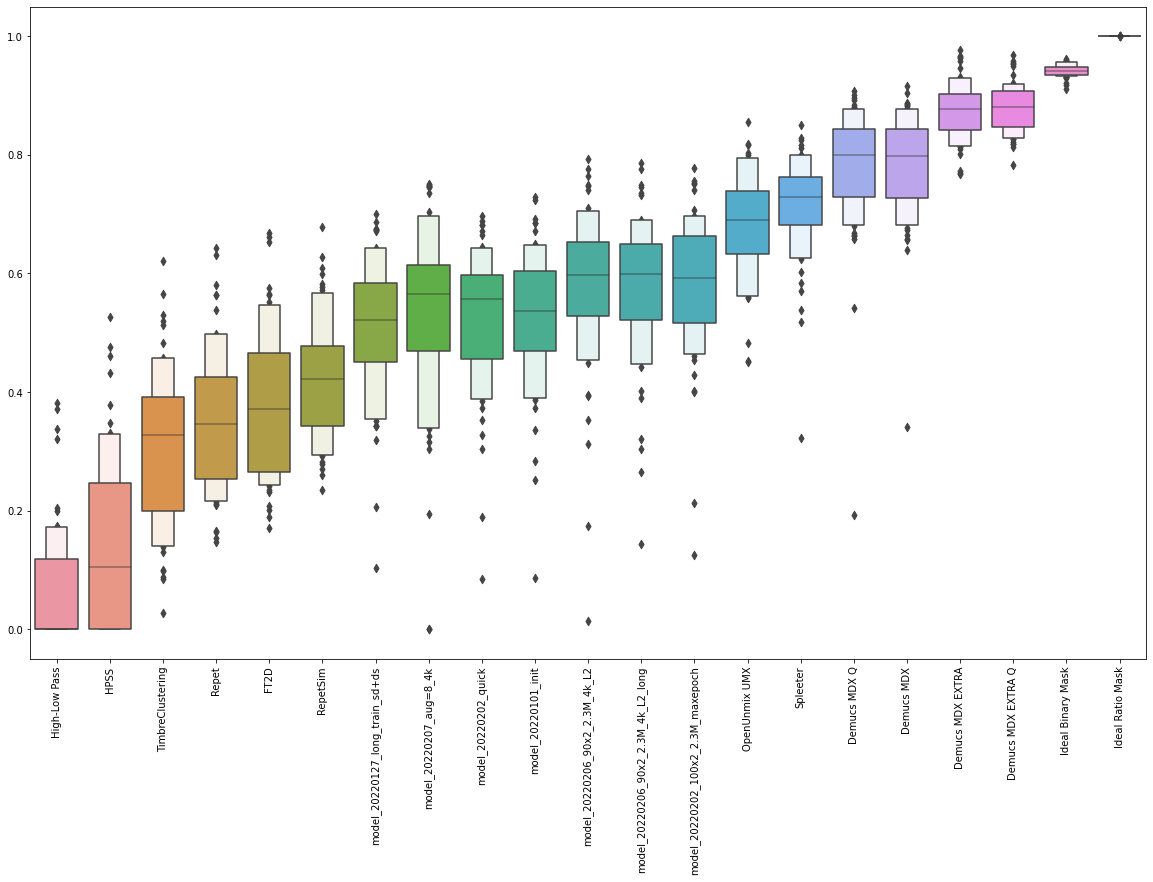

In [ ]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.transpose()),index=df.columns).transpose()
plt.figure(figsize=(20,12))
sns.boxenplot(data=df_scaled)
plt.xticks(rotation=90)
plt.show()